In [1]:
import warnings 
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
import pandas as pd
import os

In [2]:
os.chdir('/mnt/c/Users/vadim/scRNA/scParadise/scripts_article')

In [7]:
adata = sc.read_text('Mouse_aging_brain/exprMatrix.tsv.gz')
adata = adata.T
adata.X = csc_matrix(adata.X, dtype=np.float32)
meta = pd.read_csv('Mouse_aging_brain/meta.tsv', sep='\t', index_col = 0)
adata.obs = meta
adata.raw = adata

In [8]:
adata.write_h5ad('Mouse_aging_brain/adata.h5ad')

In [2]:
adata = sc.read_h5ad('Mouse_aging_brain/adata.h5ad')

In [3]:
# Create adata_train and test datasets for model training
adata_train = adata[adata.obs['orig.ident'].isin(['young2', 'old1', 'oldex1'])].copy()
adata_test_1 = adata[adata.obs['orig.ident'].isin(['old2'])].copy()
adata_test_2 = adata[adata.obs['orig.ident'].isin(['old4'])].copy()
adata_test_3 = adata[adata.obs['orig.ident'].isin(['oldex2'])].copy()
adata_test_4 = adata[adata.obs['orig.ident'].isin(['oldex4'])].copy()
adata_test_5 = adata[adata.obs['orig.ident'].isin(['young1'])].copy()
adata_test_6 = adata[adata.obs['orig.ident'].isin(['young4'])].copy()

In [4]:
for i in [adata_train, adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6]:
    i.layers['counts'] = i.X.copy()
    sc.pp.normalize_total(i, target_sum=None)
    sc.pp.log1p(i)
    i.raw = i

In [6]:
# Find marker genes of cell types
sc.tl.rank_genes_groups(adata_train, 
                        groupby='Celltype',
                        method='t-test_overestim_var', pts = True)
# Filter marker genes of cell types
sc.tl.filter_rank_genes_groups(adata_train, 
                               min_fold_change=1.0, 
                               min_in_group_fraction=0.4,
                               key_added='filtered_rank_genes_groups')
# Create list of genes for model training
lst_genes = []
for i in adata.obs['Celltype'].unique():
    df = sc.get.rank_genes_groups_df(adata_train, group = i, key='filtered_rank_genes_groups', pval_cutoff=0.05)
    df['pts_comparizon'] = df['pct_nz_group']/df['pct_nz_reference']
    lst_genes.extend(df.sort_values(by='logfoldchanges', ascending=False).head(50)['names'].tolist())
    lst_genes.extend(df.sort_values(by='pts_comparizon', ascending=False).head(50)['names'].tolist())
lst_genes = np.unique(lst_genes).tolist()
len(lst_genes)

589

In [7]:
# Save genes for models training
df_genes = pd.DataFrame(lst_genes, columns = ['genes'])
df_genes.to_csv('Mouse_aging_brain/genes_for_AI.csv')

In [8]:
# Subset genes
genes = pd.read_csv('Mouse_aging_brain/genes_for_AI.csv')
adata_train = adata_train[:, genes.genes].copy()

In [9]:
# Balance dataset
adata_balanced = scparadise.scnoah.balance(adata_train, 
                                           sample='orig.ident',
                                           celltype_l1='Celltype')

Successfully undersampled cell types: EC, MG, AC

Successfully oversampled cell types: SMC, OPC, CPC, PC, MAC, EPC, imNeur, mNeur, OLG, TNC, NRP, MNC, Hb_EC


In [10]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_balanced,
                        path='',
                        model_name='Mouse_aging_brain_scAdam',
                        celltype_l1='celltype_l1',
                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 17668 cells, it is 90.0 % of input dataset
Test dataset contains: 1964 cells, it is 10.0 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 8.17555 | val_0_unsup_loss_numpy: 1.1633399724960327|  0:00:01s
epoch 1  | loss: 1.37869 | val_0_unsup_loss_numpy: 1.085479974746704|  0:00:02s
epoch 2  | loss: 1.03566 | val_0_unsup_loss_numpy: 1.006909966468811|  0:00:02s
epoch 3  | loss: 1.0049  | val_0_unsup_loss_numpy: 1.0006999969482422|  0:00:03s
epoch 4  | loss: 1.00116 | val_0_unsup_loss_numpy: 0.9994400143623352|  0:00:04s
epoch 5  | loss: 1.00055 | val_0_unsup_loss_numpy: 0.9982600212097168|  0:00:05s
epoch 6  | loss: 0.99758 | val_0_unsup_loss_numpy: 0.9940000176429749|  0:00:05s
epoch 7  | loss: 0.99491 | val_0_unsup_loss_numpy: 0.9880499839782715|  0:00:06s
epoch 8  | loss: 0.98769 | val_0_unsup_loss_numpy: 0.9760000109672546|

In [11]:
# Create list of test datasets
lst_test_folders = ['old2', 'old4', 'oldex2', 'oldex4', 'young1', 'young4']
lst_test_adatas = [adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6]

In [18]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Mouse_aging_brain/scadam_default/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'Mouse_aging_brain_scAdam')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'Celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_default_celltype_l1.csv',
                                          save_path = os.path.join('Mouse_aging_brain/scadam_default/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [12]:
adata_test_1 = scparadise.scadam.predict(adata_test_1, 
                                         path_model = 'Mouse_aging_brain_scAdam')
# Order cell type colors
# Celltype
celltype = np.unique(adata_test_1.obs['Celltype']).tolist()
adata_test_1.obs['Celltype'] = pd.Categorical(
    values=adata_test_1.obs['Celltype'], categories=celltype, ordered=True
)
adata_test_1.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test_1.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_1, celltype='Celltype', pred_celltype='pred_celltype_l1', key_added='pred_status_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


In [16]:
sc.pp.highly_variable_genes(
    adata_test_1,
    n_top_genes=2000,
    flavor='seurat_v3',
    layer='counts',
    subset=False
)
sc.pp.pca(adata_test_1)

In [28]:
sc.pp.neighbors(adata_test_1, n_neighbors=10)
sc.tl.umap(adata_test_1, min_dist=2, spread = 2)
adata_test_1 = adata_test_1[adata_test_1.obs['pred_status_l1'].sort_values().index,:]

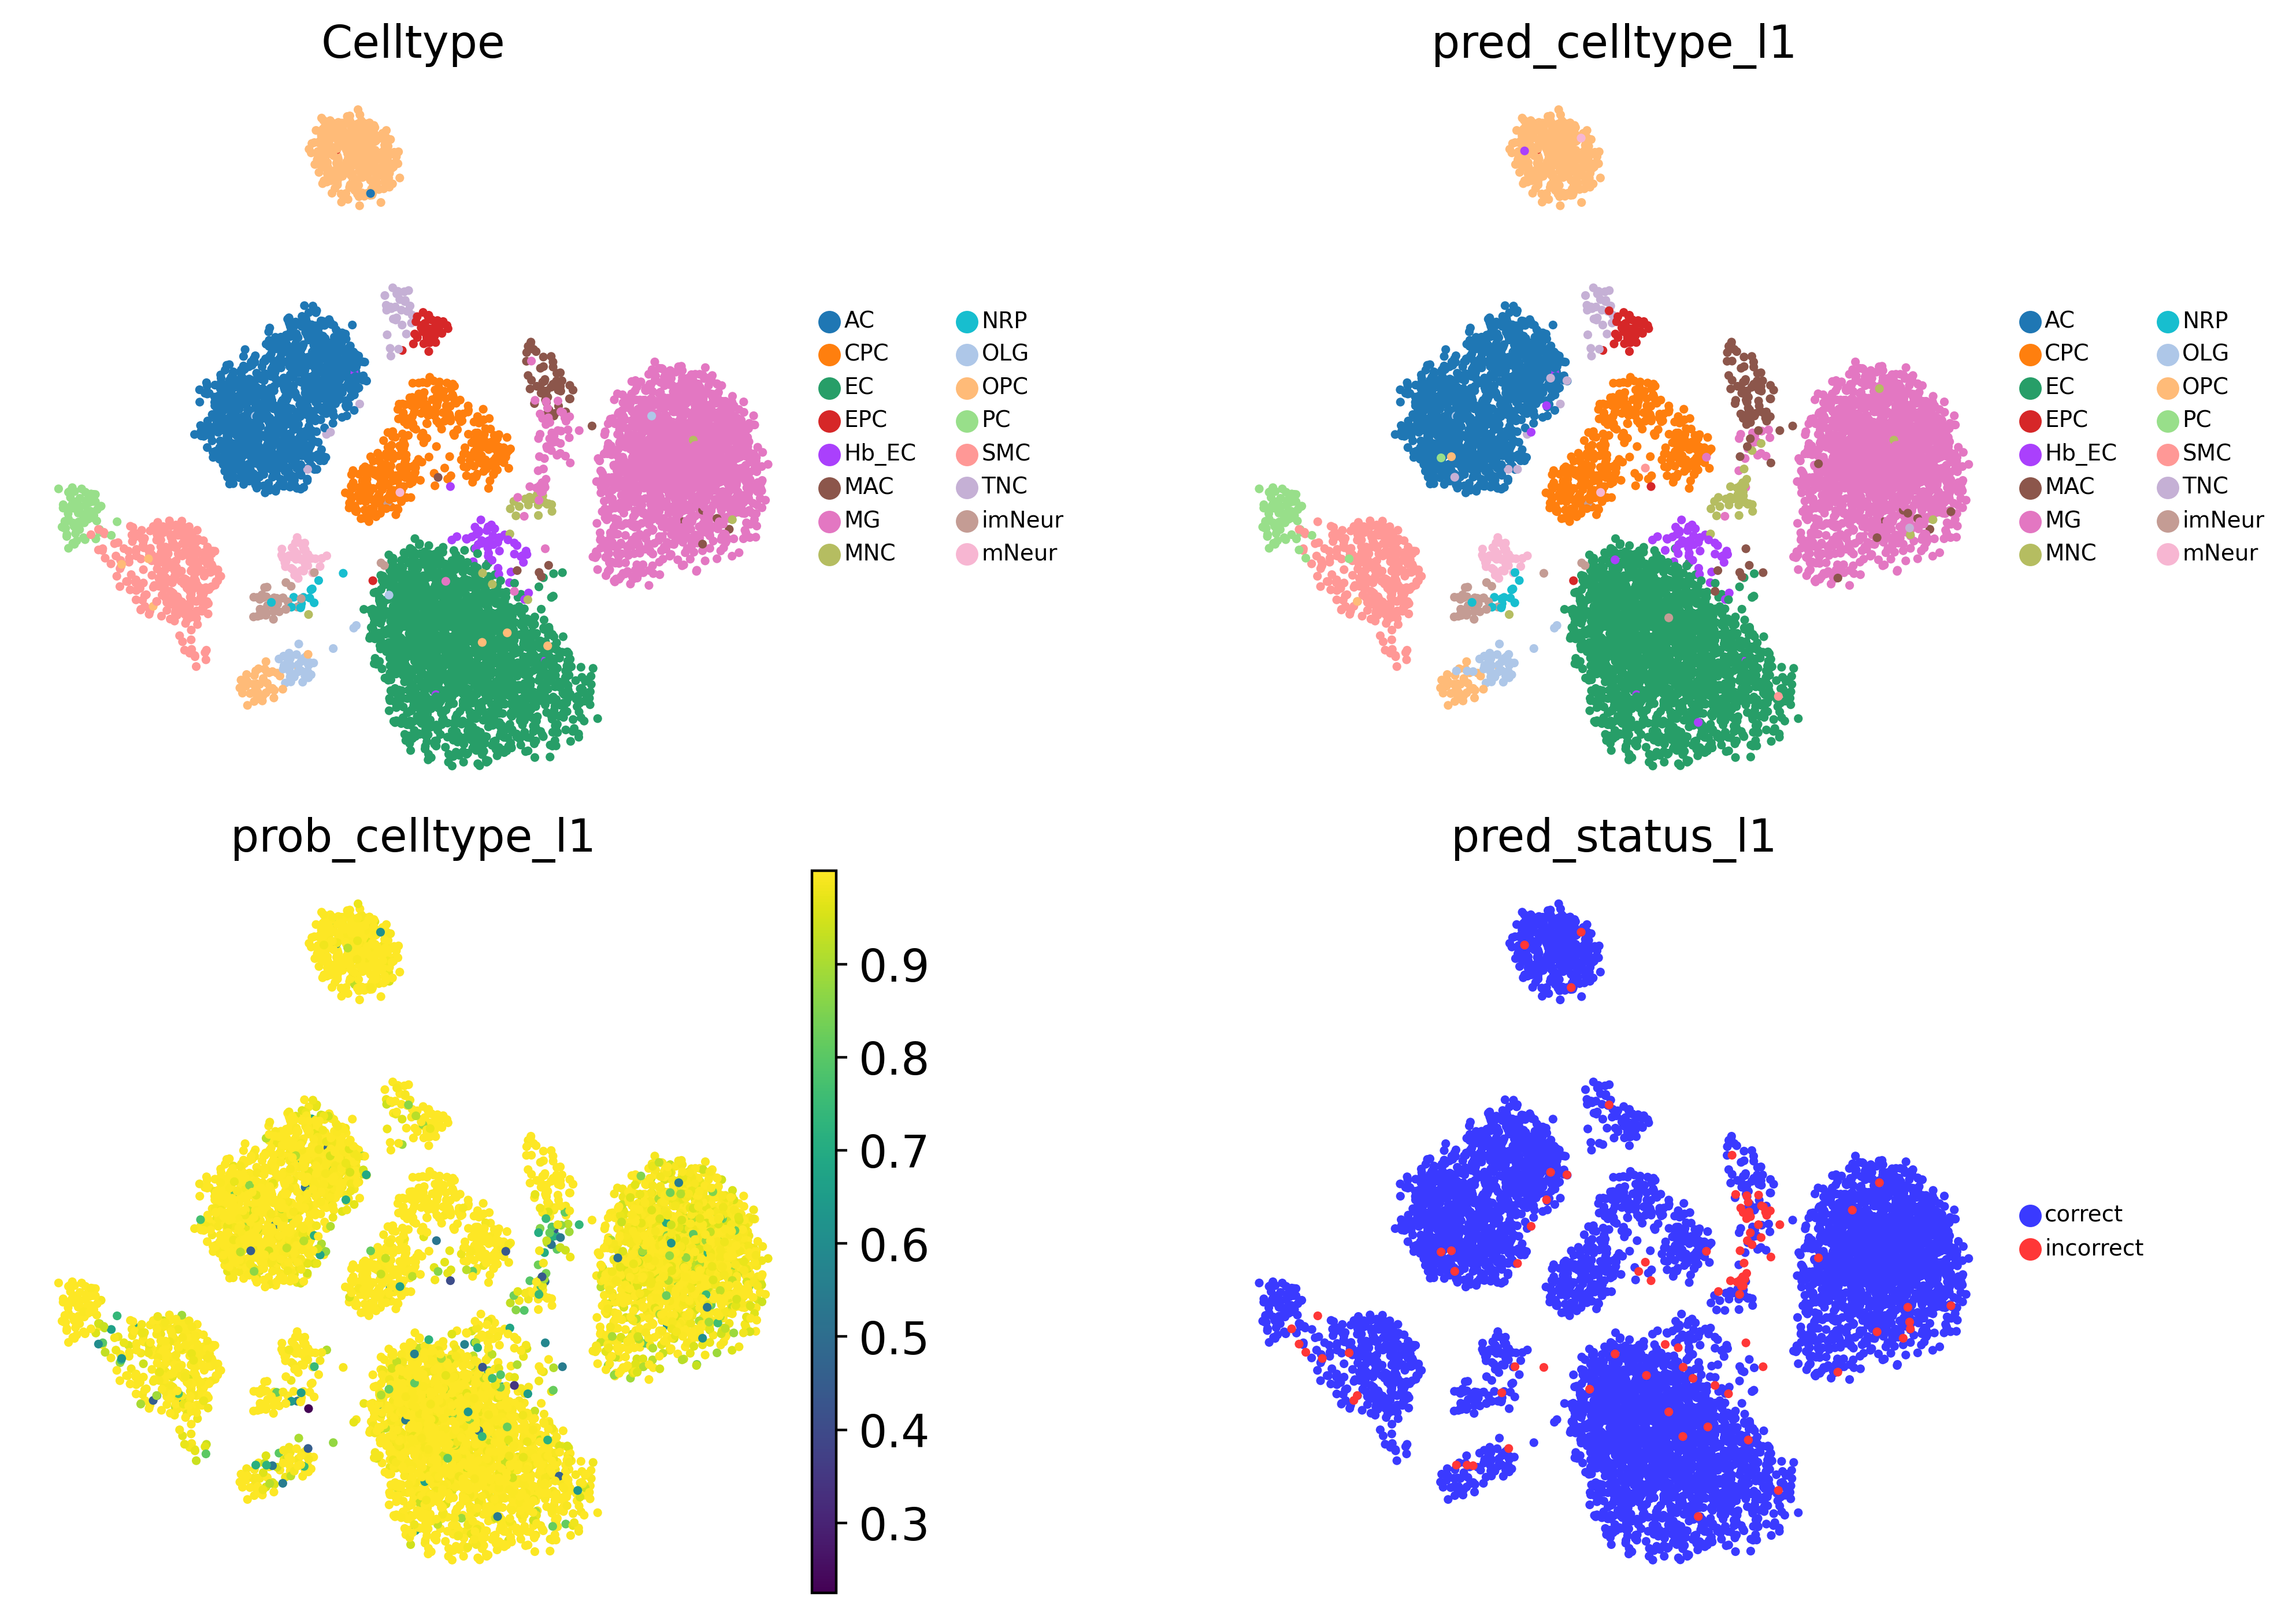

In [29]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
sc.pl.embedding(adata_test_1, 
                color=[
                    'Celltype',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status_l1'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 30,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_aging_brain_scAdam_default.png')

# Hyperparameter tuning

In [10]:
scparadise.scadam.hyperparameter_tuning(adata_balanced,
                                        path='',
                                        model_name='Mouse_aging_brain_scAdam_tuning', # Folder to save hyperparameter tuning results
                                        celltype_l1='celltype_l1',
                                        random_state=1,
                                        num_trials=200, # The number of attempts to find the optimal hyperparameters for the model (recommended - minimum 100)
                                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Accelerator: cuda



[I 2025-06-24 12:46:57,754] A new study created in RDB with name: Mouse_aging_brain_scAdam_tuning


Fold 1:

Early stopping occurred at epoch 86 with best_epoch = 76 and best_valid_accuracy = 0.98941

Fold 2:

Early stopping occurred at epoch 93 with best_epoch = 83 and best_valid_accuracy = 0.99144

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 62 and best_valid_accuracy = 0.98778

Fold 4:

Early stopping occurred at epoch 61 with best_epoch = 51 and best_valid_accuracy = 0.98879


[I 2025-06-24 12:53:11,008] Trial 0 finished with value: 0.9893541157294213 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.3, 'momentum': 0.02, 'lr': 0.01, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'patience': 10, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 0 with value: 0.9893541157294213.



Fold 1:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.9892

Fold 2:

Early stopping occurred at epoch 22 with best_epoch = 17 and best_valid_accuracy = 0.98981

Fold 3:

Early stopping occurred at epoch 25 with best_epoch = 20 and best_valid_accuracy = 0.99124

Fold 4:

Early stopping occurred at epoch 20 with best_epoch = 15 and best_valid_accuracy = 0.98798


[I 2025-06-24 12:54:56,256] Trial 1 finished with value: 0.9895578647106764 and parameters: {'n_d': 56, 'n_a': 96, 'n_steps': 1, 'n_shared': 4, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.1862602113776708, 'momentum': 0.14476868354678862, 'lr': 0.1984440603679119, 'mask_type': 'entmax', 'lambda_sparse': 0.007069470359901731, 'patience': 5, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 1 with value: 0.9895578647106764.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_accuracy = 0.97616

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.97983

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.99002

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_accuracy = 0.97922


[I 2025-06-24 13:11:52,982] Trial 2 finished with value: 0.9813060309698451 and parameters: {'n_d': 32, 'n_a': 104, 'n_steps': 10, 'n_shared': 4, 'cat_emb_dim': 7, 'n_independent': 9, 'gamma': 1.8946066635038474, 'momentum': 0.04316724243421339, 'lr': 0.01962348613811789, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0001842617343186264, 'patience': 10, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 2304}. Best is trial 1 with value: 0.9895578647106764.



Fold 1:

Early stopping occurred at epoch 10 with best_epoch = 5 and best_valid_accuracy = 0.10391


[I 2025-06-24 13:12:24,478] Trial 3 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 49 and best_valid_accuracy = 0.98859

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 86 and best_valid_accuracy = 0.99185

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 36 and best_valid_accuracy = 0.95844


[I 2025-06-24 13:20:10,311] Trial 4 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 62 and best_valid_accuracy = 0.96883

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 61 and best_valid_accuracy = 0.95844

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 56 and best_valid_accuracy = 0.99246

Fold 4:
Stop training because you reached max_epochs = 65 with best_epoch = 64 and best_valid_accuracy = 0.9839


[I 2025-06-24 13:33:50,533] Trial 5 finished with value: 0.9759066829665852 and parameters: {'n_d': 120, 'n_a': 48, 'n_steps': 8, 'n_shared': 8, 'cat_emb_dim': 9, 'n_independent': 7, 'gamma': 1.7509424340273372, 'momentum': 0.1460703533713586, 'lr': 0.13503695309333652, 'mask_type': 'entmax', 'lambda_sparse': 0.04018595987164676, 'patience': 15, 'max_epochs': 65, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 1 with value: 0.9895578647106764.



Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_accuracy = 0.99389

Fold 2:
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_accuracy = 0.99287

Fold 3:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99491

Fold 4:
Stop training because you reached max_epochs = 70 with best_epoch = 51 and best_valid_accuracy = 0.9947


[I 2025-06-24 13:43:06,576] Trial 6 finished with value: 0.9940912795436023 and parameters: {'n_d': 36, 'n_a': 120, 'n_steps': 6, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 4, 'gamma': 1.5270581022576093, 'momentum': 0.3555174187312021, 'lr': 0.17869915302524964, 'mask_type': 'entmax', 'lambda_sparse': 0.00011033189053588348, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 6 with value: 0.9940912795436023.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.93602


[I 2025-06-24 13:44:47,913] Trial 7 pruned. 


Fold 1:
Stop training because you reached max_epochs = 25 with best_epoch = 24 and best_valid_accuracy = 0.95518

Fold 2:
Stop training because you reached max_epochs = 25 with best_epoch = 23 and best_valid_accuracy = 0.96923

Fold 3:
Stop training because you reached max_epochs = 25 with best_epoch = 21 and best_valid_accuracy = 0.98778


[I 2025-06-24 13:47:47,974] Trial 8 pruned. 


Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 1 and best_valid_accuracy = 0.33089

Fold 2:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.38855

Fold 3:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.39079


[I 2025-06-24 13:48:11,063] Trial 9 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 34 and best_valid_accuracy = 0.98757


[I 2025-06-24 13:50:15,059] Trial 10 pruned. 


Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99165

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99246

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99389


[I 2025-06-24 13:54:49,479] Trial 11 pruned. 


Fold 1:

Early stopping occurred at epoch 35 with best_epoch = 25 and best_valid_accuracy = 0.69723


[I 2025-06-24 13:55:16,420] Trial 12 pruned. 


Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.98492


[I 2025-06-24 13:58:17,444] Trial 13 pruned. 


Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 33 and best_valid_accuracy = 0.98981

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 37 and best_valid_accuracy = 0.99267

Fold 3:

Early stopping occurred at epoch 34 with best_epoch = 24 and best_valid_accuracy = 0.99287


[I 2025-06-24 14:03:41,487] Trial 14 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 49 and best_valid_accuracy = 0.99246

Fold 2:

Early stopping occurred at epoch 40 with best_epoch = 25 and best_valid_accuracy = 0.98961

Fold 3:

Early stopping occurred at epoch 70 with best_epoch = 55 and best_valid_accuracy = 0.99348


[I 2025-06-24 14:10:11,860] Trial 15 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_valid_accuracy = 0.99165

Fold 2:

Early stopping occurred at epoch 6 with best_epoch = 1 and best_valid_accuracy = 0.37673

Fold 3:

Early stopping occurred at epoch 8 with best_epoch = 3 and best_valid_accuracy = 0.36491


[I 2025-06-24 14:12:23,990] Trial 16 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 75 and best_valid_accuracy = 0.99104

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 82 and best_valid_accuracy = 0.99063

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 88 and best_valid_accuracy = 0.99307

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.99246


[I 2025-06-24 14:16:07,575] Trial 17 finished with value: 0.9917991035044825 and parameters: {'n_d': 48, 'n_a': 92, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 7, 'n_independent': 3, 'gamma': 1.3822162134772618, 'momentum': 0.0781816800490571, 'lr': 0.3930431036385425, 'mask_type': 'entmax', 'lambda_sparse': 0.0020631055043234528, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 1024, 'batch_size': 4096}. Best is trial 6 with value: 0.9940912795436023.



Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_valid_accuracy = 0.39751


[I 2025-06-24 14:16:33,310] Trial 18 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 53 and best_valid_accuracy = 0.98452

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 55 and best_valid_accuracy = 0.98676

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 57 and best_valid_accuracy = 0.98696


[I 2025-06-24 14:18:28,459] Trial 19 pruned. 


Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.43154

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 69 and best_valid_accuracy = 0.52078

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.73859


[I 2025-06-24 14:21:03,663] Trial 20 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 79 and best_valid_accuracy = 0.99205

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.99368

Fold 3:

Early stopping occurred at epoch 74 with best_epoch = 59 and best_valid_accuracy = 0.99348

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.9945


[I 2025-06-24 14:24:32,310] Trial 21 finished with value: 0.9934290953545232 and parameters: {'n_d': 60, 'n_a': 92, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 5, 'n_independent': 2, 'gamma': 1.4830238566975953, 'momentum': 0.07673737129573359, 'lr': 0.23961922119353307, 'mask_type': 'entmax', 'lambda_sparse': 0.0046383004805246675, 'patience': 15, 'max_epochs': 85, 'virtual_batch_size': 1024, 'batch_size': 3072}. Best is trial 6 with value: 0.9940912795436023.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99144

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 84 and best_valid_accuracy = 0.99348

Fold 3:

Early stopping occurred at epoch 78 with best_epoch = 63 and best_valid_accuracy = 0.99368

Fold 4:

Early stopping occurred at epoch 63 with best_epoch = 48 and best_valid_accuracy = 0.98981


[I 2025-06-24 14:27:53,552] Trial 22 finished with value: 0.9921047269763651 and parameters: {'n_d': 48, 'n_a': 68, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 5, 'n_independent': 3, 'gamma': 1.4888967945961586, 'momentum': 0.06665879533289652, 'lr': 0.305341755012438, 'mask_type': 'entmax', 'lambda_sparse': 0.003688454709061824, 'patience': 15, 'max_epochs': 90, 'virtual_batch_size': 1024, 'batch_size': 3072}. Best is trial 6 with value: 0.9940912795436023.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.989

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 68 and best_valid_accuracy = 0.99063

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.97596


[I 2025-06-24 14:30:41,763] Trial 23 pruned. 


Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 60 and best_valid_accuracy = 0.99267

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 74 and best_valid_accuracy = 0.99205

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 72 and best_valid_accuracy = 0.9945

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 70 and best_valid_accuracy = 0.99348


[I 2025-06-24 14:33:57,639] Trial 24 finished with value: 0.9931744091279543 and parameters: {'n_d': 36, 'n_a': 44, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 5, 'n_independent': 3, 'gamma': 1.4739051772013523, 'momentum': 0.10898970416558085, 'lr': 0.23125068588852987, 'mask_type': 'entmax', 'lambda_sparse': 0.013313161381864301, 'patience': 15, 'max_epochs': 80, 'virtual_batch_size': 1024, 'batch_size': 3072}. Best is trial 6 with value: 0.9940912795436023.



Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 26 and best_valid_accuracy = 0.978

Fold 2:

Early stopping occurred at epoch 26 with best_epoch = 11 and best_valid_accuracy = 0.98085

Fold 3:

Early stopping occurred at epoch 40 with best_epoch = 25 and best_valid_accuracy = 0.97698


[I 2025-06-24 14:44:21,098] Trial 25 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.97188


[I 2025-06-24 14:45:48,636] Trial 26 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 53 and best_valid_accuracy = 0.98757


[I 2025-06-24 14:46:40,090] Trial 27 pruned. 


Fold 1:

Early stopping occurred at epoch 67 with best_epoch = 52 and best_valid_accuracy = 0.98941


[I 2025-06-24 14:51:42,850] Trial 28 pruned. 


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.99267

Fold 2:

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.99144

Fold 3:

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.99246


[I 2025-06-24 14:53:52,351] Trial 29 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 70 and best_valid_accuracy = 0.99368

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 76 and best_valid_accuracy = 0.99409

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 83 and best_valid_accuracy = 0.99593

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 79 and best_valid_accuracy = 0.99511


[I 2025-06-24 14:57:25,019] Trial 30 finished with value: 0.9947025264873676 and parameters: {'n_d': 116, 'n_a': 32, 'n_steps': 4, 'n_shared': 5, 'cat_emb_dim': 4, 'n_independent': 2, 'gamma': 1.5554774868030807, 'momentum': 0.09504127849735913, 'lr': 0.095242501447443, 'mask_type': 'entmax', 'lambda_sparse': 0.02604733466835242, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 30 with value: 0.9947025264873676.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99409

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 78 and best_valid_accuracy = 0.9943

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 83 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.9943


[I 2025-06-24 15:00:59,353] Trial 31 finished with value: 0.994855338223309 and parameters: {'n_d': 128, 'n_a': 32, 'n_steps': 4, 'n_shared': 6, 'cat_emb_dim': 4, 'n_independent': 2, 'gamma': 1.5595308996235826, 'momentum': 0.10067233097248869, 'lr': 0.08662630724705549, 'mask_type': 'entmax', 'lambda_sparse': 0.024688383237406523, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 31 with value: 0.994855338223309.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.99389

Fold 2:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99491

Fold 3:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.99654


[I 2025-06-24 15:05:07,292] Trial 32 finished with value: 0.9953647106764466 and parameters: {'n_d': 116, 'n_a': 28, 'n_steps': 4, 'n_shared': 7, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.5496582466828417, 'momentum': 0.04516072455044329, 'lr': 0.059421301296154125, 'mask_type': 'entmax', 'lambda_sparse': 0.023879859056972836, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 32 with value: 0.9953647106764466.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 91 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 77 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.99633


[I 2025-06-24 15:09:03,801] Trial 33 finished with value: 0.995975957620212 and parameters: {'n_d': 128, 'n_a': 28, 'n_steps': 4, 'n_shared': 7, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.692339086385724, 'momentum': 0.04187960319522321, 'lr': 0.05519176978792362, 'mask_type': 'entmax', 'lambda_sparse': 0.023922729536026466, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 82 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.9947

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.99552

Fold 4:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99205


[I 2025-06-24 15:12:35,108] Trial 34 finished with value: 0.9943459657701712 and parameters: {'n_d': 128, 'n_a': 28, 'n_steps': 4, 'n_shared': 7, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.8040692942144974, 'momentum': 0.04403897732477927, 'lr': 0.05249738775611016, 'mask_type': 'entmax', 'lambda_sparse': 0.026719110233539352, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99348

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 91 and best_valid_accuracy = 0.99511

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 91 and best_valid_accuracy = 0.99491

Fold 4:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.9947


[I 2025-06-24 15:16:02,342] Trial 35 finished with value: 0.9945497147514262 and parameters: {'n_d': 112, 'n_a': 8, 'n_steps': 3, 'n_shared': 7, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.6935958264237203, 'momentum': 0.010641276157893127, 'lr': 0.0629875539279683, 'mask_type': 'entmax', 'lambda_sparse': 0.02168117747677782, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 84 and best_valid_accuracy = 0.99389

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.99368

Fold 3:

Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.99409

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.99328


[I 2025-06-24 15:20:37,809] Trial 36 finished with value: 0.9937347188264058 and parameters: {'n_d': 108, 'n_a': 20, 'n_steps': 5, 'n_shared': 7, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.8742422978837046, 'momentum': 0.04503566092597448, 'lr': 0.038228575253892186, 'mask_type': 'entmax', 'lambda_sparse': 0.04486176527007605, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.99409

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 81 and best_valid_accuracy = 0.99328

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 83 and best_valid_accuracy = 0.99348


[I 2025-06-24 15:25:14,598] Trial 37 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_valid_accuracy = 0.99552

Fold 2:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.9945

Fold 3:

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.99531

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_accuracy = 0.99593


[I 2025-06-24 15:28:42,565] Trial 38 finished with value: 0.9953137734311328 and parameters: {'n_d': 116, 'n_a': 36, 'n_steps': 3, 'n_shared': 5, 'cat_emb_dim': 4, 'n_independent': 2, 'gamma': 1.8354975017558206, 'momentum': 0.05642618005223875, 'lr': 0.10382555676057995, 'mask_type': 'entmax', 'lambda_sparse': 0.0466222122135961, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 83 and best_valid_accuracy = 0.99511

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99409

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_accuracy = 0.99552

Fold 4:

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.99572


[I 2025-06-24 15:33:02,713] Trial 39 finished with value: 0.9951100244498778 and parameters: {'n_d': 104, 'n_a': 20, 'n_steps': 3, 'n_shared': 9, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8735240455228903, 'momentum': 0.05117695609189762, 'lr': 0.025950694587070215, 'mask_type': 'entmax', 'lambda_sparse': 0.04362259114625125, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.99287

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 85 and best_valid_accuracy = 0.99022

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.99165


[I 2025-06-24 15:36:39,620] Trial 40 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 90 and best_valid_accuracy = 0.99552

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 75 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 80 and best_valid_accuracy = 0.99572


[I 2025-06-24 15:40:32,714] Trial 41 finished with value: 0.9957212713936431 and parameters: {'n_d': 124, 'n_a': 36, 'n_steps': 3, 'n_shared': 9, 'cat_emb_dim': 1, 'n_independent': 2, 'gamma': 1.8597964138067828, 'momentum': 0.023151904488028858, 'lr': 0.03325095844942921, 'mask_type': 'entmax', 'lambda_sparse': 0.02058197626775192, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99552

Fold 2:

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_accuracy = 0.9947

Fold 3:

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_accuracy = 0.99593

Fold 4:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99613


[I 2025-06-24 15:44:48,514] Trial 42 finished with value: 0.9955684596577017 and parameters: {'n_d': 120, 'n_a': 40, 'n_steps': 3, 'n_shared': 9, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8668863774112245, 'momentum': 0.029194068020277415, 'lr': 0.03534956877675687, 'mask_type': 'entmax', 'lambda_sparse': 0.018303292554971567, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.99531

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.99511

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 86 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.99552


[I 2025-06-24 15:48:29,589] Trial 43 finished with value: 0.9955175224123879 and parameters: {'n_d': 120, 'n_a': 40, 'n_steps': 3, 'n_shared': 9, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.80558027950465, 'momentum': 0.027126971194807135, 'lr': 0.12205033064670895, 'mask_type': 'entmax', 'lambda_sparse': 0.021012612878756106, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.97922

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.97901

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.97901


[I 2025-06-24 15:51:46,343] Trial 44 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 90 and best_valid_accuracy = 0.99226


[I 2025-06-24 15:52:56,621] Trial 45 pruned. 


Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99531

Fold 2:

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 83 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.99613


[I 2025-06-24 15:55:46,449] Trial 46 finished with value: 0.9958231458842706 and parameters: {'n_d': 92, 'n_a': 52, 'n_steps': 1, 'n_shared': 8, 'cat_emb_dim': 2, 'n_independent': 2, 'gamma': 1.816407897719607, 'momentum': 0.010567414222549289, 'lr': 0.040549293930388496, 'mask_type': 'entmax', 'lambda_sparse': 0.015595916839311736, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.83863


[I 2025-06-24 15:55:49,701] Trial 47 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 78 and best_valid_accuracy = 0.99511

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.9947

Fold 3:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99531


[I 2025-06-24 15:58:14,018] Trial 48 pruned. 


Fold 1:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.99654

Fold 4:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99593


[I 2025-06-24 16:01:04,366] Trial 49 finished with value: 0.9956703341483293 and parameters: {'n_d': 124, 'n_a': 40, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 2, 'n_independent': 2, 'gamma': 1.7767141808619171, 'momentum': 0.1347297639333952, 'lr': 0.03181435667884977, 'mask_type': 'entmax', 'lambda_sparse': 0.03490453076339282, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99409

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 60 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99511


[I 2025-06-24 16:03:43,050] Trial 50 finished with value: 0.9952118989405053 and parameters: {'n_d': 84, 'n_a': 52, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 1, 'n_independent': 2, 'gamma': 1.759543030064613, 'momentum': 0.1485813618056743, 'lr': 0.04603796354351806, 'mask_type': 'entmax', 'lambda_sparse': 0.010055538190007991, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 33 with value: 0.995975957620212.



Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99348

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.99491

Fold 3:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.99572

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 88 and best_valid_accuracy = 0.99633


[I 2025-06-24 16:06:46,302] Trial 51 finished with value: 0.9951100244498777 and parameters: {'n_d': 124, 'n_a': 44, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 2, 'n_independent': 2, 'gamma': 1.7902340565828618, 'momentum': 0.02717065355530224, 'lr': 0.11734824782771909, 'mask_type': 'entmax', 'lambda_sparse': 0.03415112477623198, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 33 with value: 0.995975957620212.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 87 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 89 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 80 and best_valid_accuracy = 0.99674


[I 2025-06-24 16:10:29,989] Trial 52 finished with value: 0.996179706601467 and parameters: {'n_d': 108, 'n_a': 40, 'n_steps': 2, 'n_shared': 10, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.9203193895037018, 'momentum': 0.1250953373486947, 'lr': 0.022968652147406142, 'mask_type': 'entmax', 'lambda_sparse': 0.019894145409049675, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 52 with value: 0.996179706601467.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99368


[I 2025-06-24 16:11:26,600] Trial 53 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99531

Fold 2:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99552

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 77 and best_valid_accuracy = 0.99572


[I 2025-06-24 16:14:58,101] Trial 54 finished with value: 0.9956703341483293 and parameters: {'n_d': 108, 'n_a': 24, 'n_steps': 1, 'n_shared': 8, 'cat_emb_dim': 2, 'n_independent': 3, 'gamma': 1.8648212064542073, 'momentum': 0.1276355870614778, 'lr': 0.07563277303267968, 'mask_type': 'entmax', 'lambda_sparse': 0.017646490040290595, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1792}. Best is trial 52 with value: 0.996179706601467.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99593


[I 2025-06-24 16:17:29,068] Trial 55 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 75 and best_valid_accuracy = 0.9945

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 70 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99368


[I 2025-06-24 16:19:38,119] Trial 56 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 73 and best_valid_accuracy = 0.25672


[I 2025-06-24 16:20:32,443] Trial 57 pruned. 


Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 39 and best_valid_accuracy = 0.99205


[I 2025-06-24 16:21:06,930] Trial 58 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.9945

Fold 3:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.9947


[I 2025-06-24 16:23:26,006] Trial 59 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_accuracy = 0.99104


[I 2025-06-24 16:23:55,880] Trial 60 pruned. 


Fold 1:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 77 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99552


[I 2025-06-24 16:26:42,508] Trial 61 finished with value: 0.9962815810920945 and parameters: {'n_d': 124, 'n_a': 32, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8714642863268125, 'momentum': 0.11952987881139675, 'lr': 0.03308670392726156, 'mask_type': 'entmax', 'lambda_sparse': 0.015491097747128556, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99409


[I 2025-06-24 16:27:21,166] Trial 62 pruned. 


Fold 1:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99715

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.99633


[I 2025-06-24 16:30:23,285] Trial 63 finished with value: 0.9962815810920945 and parameters: {'n_d': 108, 'n_a': 32, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8860527179377378, 'momentum': 0.16757812241530412, 'lr': 0.02369129679672964, 'mask_type': 'entmax', 'lambda_sparse': 0.010764283275371945, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99491

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.99674


[I 2025-06-24 16:34:06,650] Trial 64 finished with value: 0.9959759576202118 and parameters: {'n_d': 128, 'n_a': 32, 'n_steps': 2, 'n_shared': 10, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.9487908262217366, 'momentum': 0.17592763657913724, 'lr': 0.02345099575017818, 'mask_type': 'entmax', 'lambda_sparse': 0.01168497320204637, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:
Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_valid_accuracy = 0.98207


[I 2025-06-24 16:34:21,298] Trial 65 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.9947

Fold 2:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99267

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99531


[I 2025-06-24 16:36:21,637] Trial 66 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 62 and best_valid_accuracy = 0.9943


[I 2025-06-24 16:37:09,051] Trial 67 pruned. 


Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 54 and best_valid_accuracy = 0.99409


[I 2025-06-24 16:37:55,054] Trial 68 pruned. 


Fold 1:

Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.99491

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_valid_accuracy = 0.99674

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_accuracy = 0.99654


[I 2025-06-24 16:40:47,979] Trial 69 finished with value: 0.9960268948655256 and parameters: {'n_d': 104, 'n_a': 48, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8971198989623548, 'momentum': 0.08110704804588073, 'lr': 0.040671356479681245, 'mask_type': 'entmax', 'lambda_sparse': 0.0029451465748494, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99491

Fold 3:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.99613


[I 2025-06-24 16:44:25,086] Trial 70 finished with value: 0.995925020374898 and parameters: {'n_d': 104, 'n_a': 64, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.941836970116344, 'momentum': 0.08276744935119335, 'lr': 0.046835277181016606, 'mask_type': 'entmax', 'lambda_sparse': 0.002838429187913682, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.1738


[I 2025-06-24 16:45:31,044] Trial 71 pruned. 


Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99409

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_valid_accuracy = 0.99572

Fold 3:

Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.99613

Fold 4:

Early stopping occurred at epoch 98 with best_epoch = 78 and best_valid_accuracy = 0.99633


[I 2025-06-24 16:49:44,061] Trial 72 finished with value: 0.9955684596577017 and parameters: {'n_d': 96, 'n_a': 52, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 2, 'n_independent': 9, 'gamma': 1.8845646287549758, 'momentum': 0.11166510159711007, 'lr': 0.04514563349347137, 'mask_type': 'entmax', 'lambda_sparse': 0.0016980411458865437, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 61 with value: 0.9962815810920945.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.9943

Fold 3:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.9947


[I 2025-06-24 16:52:07,661] Trial 73 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.99572

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 66 and best_valid_accuracy = 0.99552

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 67 and best_valid_accuracy = 0.99715

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99694


[I 2025-06-24 16:54:56,972] Trial 74 finished with value: 0.9963325183374083 and parameters: {'n_d': 112, 'n_a': 80, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.8251453051047106, 'momentum': 0.13967590618088843, 'lr': 0.024411827932043925, 'mask_type': 'entmax', 'lambda_sparse': 0.0036422990637857942, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 74 with value: 0.9963325183374083.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 77 and best_valid_accuracy = 0.9947

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 73 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.99552


[I 2025-06-24 16:57:51,670] Trial 75 pruned. 


Fold 1:

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99593


[I 2025-06-24 17:02:22,358] Trial 76 finished with value: 0.9965872045639772 and parameters: {'n_d': 108, 'n_a': 84, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9785775271832842, 'momentum': 0.09921333258141778, 'lr': 0.0523392126078312, 'mask_type': 'entmax', 'lambda_sparse': 0.0017358362451066762, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99287

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 83 and best_valid_accuracy = 0.9943

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.99409


[I 2025-06-24 17:11:36,635] Trial 77 pruned. 


Fold 1:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.99694

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99572


[I 2025-06-24 17:15:41,417] Trial 78 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 56 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99694

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99654


[I 2025-06-24 17:19:35,838] Trial 79 finished with value: 0.9958740831295844 and parameters: {'n_d': 128, 'n_a': 96, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.040374518171103, 'momentum': 0.1957197099250959, 'lr': 0.013397657787479826, 'mask_type': 'entmax', 'lambda_sparse': 0.001340158498339272, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 20 with best_epoch = 5 and best_valid_accuracy = 0.41137


[I 2025-06-24 17:20:02,011] Trial 80 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.9945

Fold 2:

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_accuracy = 0.9947

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 87 and best_valid_accuracy = 0.99633

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_valid_accuracy = 0.99572


[I 2025-06-24 17:23:21,755] Trial 81 finished with value: 0.9953137734311329 and parameters: {'n_d': 104, 'n_a': 84, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.9489393836048268, 'momentum': 0.06333256003180292, 'lr': 0.028458641422120654, 'mask_type': 'entmax', 'lambda_sparse': 0.0026907423256018314, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.99674

Fold 3:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99633

Fold 4:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99348


[I 2025-06-24 17:26:07,434] Trial 82 finished with value: 0.9956703341483293 and parameters: {'n_d': 120, 'n_a': 104, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.89386973793721, 'momentum': 0.091631540386742, 'lr': 0.04774497975316237, 'mask_type': 'entmax', 'lambda_sparse': 0.002173738814694709, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_accuracy = 0.9943

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99552


[I 2025-06-24 17:28:17,007] Trial 83 pruned. 


Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.97107


[I 2025-06-24 17:31:45,160] Trial 84 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 83 and best_valid_accuracy = 0.99348


[I 2025-06-24 17:32:24,628] Trial 85 pruned. 


Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 53 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 46 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 64 with best_epoch = 54 and best_valid_accuracy = 0.99593

Fold 4:

Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.9947


[I 2025-06-24 17:34:23,446] Trial 86 finished with value: 0.9954156479217604 and parameters: {'n_d': 116, 'n_a': 92, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.9226878108742795, 'momentum': 0.10436853814360605, 'lr': 0.03625399329281342, 'mask_type': 'entmax', 'lambda_sparse': 0.009760398024337888, 'patience': 10, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 77 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99674

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 83 and best_valid_accuracy = 0.99593


[I 2025-06-24 17:38:28,992] Trial 87 finished with value: 0.9957722086389567 and parameters: {'n_d': 104, 'n_a': 84, 'n_steps': 2, 'n_shared': 7, 'cat_emb_dim': 3, 'n_independent': 5, 'gamma': 1.812840058694304, 'momentum': 0.17804550600924968, 'lr': 0.10176915451565624, 'mask_type': 'entmax', 'lambda_sparse': 0.004001652863554318, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 63 and best_valid_accuracy = 0.99389


[I 2025-06-24 17:39:33,482] Trial 88 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.98615

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.98635

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.93908


[I 2025-06-24 17:46:57,883] Trial 89 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 68 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.99613


[I 2025-06-24 17:50:24,676] Trial 90 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99654

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 66 and best_valid_accuracy = 0.99674

Fold 4:
Stop training because you reached max_epochs = 75 with best_epoch = 64 and best_valid_accuracy = 0.99674


[I 2025-06-24 17:55:21,993] Trial 91 finished with value: 0.9962306438467807 and parameters: {'n_d': 128, 'n_a': 112, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.6288852091059252, 'momentum': 0.18968367820210552, 'lr': 0.00955184724056501, 'mask_type': 'entmax', 'lambda_sparse': 0.0013029013673171652, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99348

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.9943


[I 2025-06-24 17:59:16,235] Trial 92 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 81 and best_valid_accuracy = 0.97555


[I 2025-06-24 18:00:35,027] Trial 93 pruned. 


Fold 1:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.99531

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99674

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.99633


[I 2025-06-24 18:06:26,653] Trial 94 finished with value: 0.9960778321108394 and parameters: {'n_d': 124, 'n_a': 112, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.6912100265562031, 'momentum': 0.14030832756485162, 'lr': 0.04072148836959348, 'mask_type': 'entmax', 'lambda_sparse': 0.023256733585709625, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.99654

Fold 4:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99756


[I 2025-06-24 18:13:37,221] Trial 95 finished with value: 0.9964343928280359 and parameters: {'n_d': 128, 'n_a': 112, 'n_steps': 2, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5954027623450662, 'momentum': 0.13648733436365462, 'lr': 0.026244439127631945, 'mask_type': 'entmax', 'lambda_sparse': 0.02366714964967784, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99572

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99654

Fold 4:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99654


[I 2025-06-24 18:18:53,800] Trial 96 finished with value: 0.9961287693561532 and parameters: {'n_d': 120, 'n_a': 112, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.6037111761126897, 'momentum': 0.1889084749901051, 'lr': 0.038822177273840276, 'mask_type': 'entmax', 'lambda_sparse': 0.023056464923277665, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99572


[I 2025-06-24 18:24:20,578] Trial 97 finished with value: 0.996179706601467 and parameters: {'n_d': 116, 'n_a': 112, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.6144829522488429, 'momentum': 0.13832979034050838, 'lr': 0.03497415601499455, 'mask_type': 'entmax', 'lambda_sparse': 0.022491514047301098, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.9945

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99613


[I 2025-06-24 18:29:37,995] Trial 98 finished with value: 0.995925020374898 and parameters: {'n_d': 120, 'n_a': 112, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.5953387899423737, 'momentum': 0.14030800031288587, 'lr': 0.06703072792279258, 'mask_type': 'entmax', 'lambda_sparse': 0.02259807067484556, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.9943

Fold 2:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.9947

Fold 3:
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_accuracy = 0.99715

Fold 4:
Stop training because you reached max_epochs = 70 with best_epoch = 61 and best_valid_accuracy = 0.99674


[I 2025-06-24 18:33:34,181] Trial 99 finished with value: 0.995721271393643 and parameters: {'n_d': 124, 'n_a': 124, 'n_steps': 1, 'n_shared': 8, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.5945105059396556, 'momentum': 0.167938028523698, 'lr': 0.03012537298163047, 'mask_type': 'entmax', 'lambda_sparse': 0.027644615217508658, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 62 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99613

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.9945


[I 2025-06-24 18:40:31,478] Trial 100 finished with value: 0.995262836185819 and parameters: {'n_d': 116, 'n_a': 108, 'n_steps': 2, 'n_shared': 8, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.530233425411871, 'momentum': 0.15624055098396727, 'lr': 0.012291300426223046, 'mask_type': 'entmax', 'lambda_sparse': 0.016614103771542668, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 74 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 85 and best_valid_accuracy = 0.99756

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99694


[I 2025-06-24 18:45:42,019] Trial 101 finished with value: 0.9963325183374083 and parameters: {'n_d': 112, 'n_a': 116, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6234070642426672, 'momentum': 0.1871051518750006, 'lr': 0.04060553361956297, 'mask_type': 'entmax', 'lambda_sparse': 0.023086298420211187, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.99654

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99613


[I 2025-06-24 18:51:26,985] Trial 102 finished with value: 0.9964343928280358 and parameters: {'n_d': 120, 'n_a': 116, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6221109130407891, 'momentum': 0.1903355679057402, 'lr': 0.036731715474536415, 'mask_type': 'entmax', 'lambda_sparse': 0.0209665653987961, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99491

Fold 3:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99572


[I 2025-06-24 18:55:06,333] Trial 103 pruned. 


Fold 1:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99409


[I 2025-06-24 18:55:58,684] Trial 104 pruned. 


Fold 1:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.9943

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 77 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99633

Fold 4:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99531


[I 2025-06-24 19:02:17,621] Trial 105 finished with value: 0.9953137734311328 and parameters: {'n_d': 108, 'n_a': 128, 'n_steps': 2, 'n_shared': 8, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.572996878818137, 'momentum': 0.1845766848792525, 'lr': 0.08277484398336533, 'mask_type': 'entmax', 'lambda_sparse': 0.026685382703298045, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.9943


[I 2025-06-24 19:03:17,914] Trial 106 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.9945

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99613


[I 2025-06-24 19:06:07,501] Trial 107 pruned. 


Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 66 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 67 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.99756


[I 2025-06-24 19:13:53,157] Trial 108 finished with value: 0.9963834555827221 and parameters: {'n_d': 120, 'n_a': 120, 'n_steps': 2, 'n_shared': 8, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5049686896581, 'momentum': 0.18344219136909143, 'lr': 0.02149594283730237, 'mask_type': 'sparsemax', 'lambda_sparse': 0.015713996288188474, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.97942


[I 2025-06-24 19:15:38,729] Trial 109 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 65 and best_valid_accuracy = 0.9947

Fold 2:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.9943

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 59 and best_valid_accuracy = 0.99654

Fold 4:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99694


[I 2025-06-24 19:22:50,627] Trial 110 finished with value: 0.9956193969030155 and parameters: {'n_d': 112, 'n_a': 124, 'n_steps': 2, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5277531493780414, 'momentum': 0.20375798997684336, 'lr': 0.019030319091509703, 'mask_type': 'sparsemax', 'lambda_sparse': 0.04063507268362598, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.9947


[I 2025-06-24 19:25:57,837] Trial 111 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.9945

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 50 and best_valid_accuracy = 0.9945

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 52 and best_valid_accuracy = 0.99593


[I 2025-06-24 19:29:13,059] Trial 112 pruned. 


Fold 1:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99572

Fold 3:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99511


[I 2025-06-24 19:32:00,425] Trial 113 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99572


[I 2025-06-24 19:36:32,605] Trial 114 pruned. 


Fold 1:

Early stopping occurred at epoch 24 with best_epoch = 14 and best_valid_accuracy = 0.99185


[I 2025-06-24 19:37:00,689] Trial 115 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.9947

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99674


[I 2025-06-24 19:42:25,953] Trial 116 finished with value: 0.9960268948655258 and parameters: {'n_d': 124, 'n_a': 120, 'n_steps': 2, 'n_shared': 8, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.4533015144364574, 'momentum': 0.24077339440033413, 'lr': 0.043897474789685594, 'mask_type': 'entmax', 'lambda_sparse': 0.010464290036048008, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 44 and best_valid_accuracy = 0.99328


[I 2025-06-24 19:45:23,348] Trial 117 pruned. 


Fold 1:

Early stopping occurred at epoch 24 with best_epoch = 19 and best_valid_accuracy = 0.99165

Fold 2:

Early stopping occurred at epoch 24 with best_epoch = 19 and best_valid_accuracy = 0.99348

Fold 3:

Early stopping occurred at epoch 24 with best_epoch = 19 and best_valid_accuracy = 0.99368


[I 2025-06-24 19:46:49,375] Trial 118 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.15954


[I 2025-06-24 19:47:22,854] Trial 119 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99715


[I 2025-06-24 19:52:27,402] Trial 120 finished with value: 0.9965362673186634 and parameters: {'n_d': 124, 'n_a': 112, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.5989282674072574, 'momentum': 0.11293649956063138, 'lr': 0.028127451935829422, 'mask_type': 'entmax', 'lambda_sparse': 0.0012747356580160695, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99613

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99674


[I 2025-06-24 19:56:51,981] Trial 121 finished with value: 0.9957722086389569 and parameters: {'n_d': 116, 'n_a': 112, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.5990284173895273, 'momentum': 0.11484298775180335, 'lr': 0.027899181145416948, 'mask_type': 'entmax', 'lambda_sparse': 0.0012507100483422334, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 84 and best_valid_accuracy = 0.99674

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 81 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99613

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.9945


[I 2025-06-24 20:13:56,775] Trial 122 finished with value: 0.9959250203748982 and parameters: {'n_d': 124, 'n_a': 116, 'n_steps': 7, 'n_shared': 10, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.6416384976521923, 'momentum': 0.0978278596696713, 'lr': 0.03833613921314342, 'mask_type': 'entmax', 'lambda_sparse': 0.0008544453039082896, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 77 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99633

Fold 3:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99572


[I 2025-06-24 20:18:33,692] Trial 123 finished with value: 0.9962815810920946 and parameters: {'n_d': 120, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5824413134743232, 'momentum': 0.11932240612309336, 'lr': 0.010850588176650819, 'mask_type': 'entmax', 'lambda_sparse': 0.0015963972599730809, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.9943


[I 2025-06-24 20:19:40,322] Trial 124 pruned. 


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99491

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 66 and best_valid_accuracy = 0.99694

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99531


[I 2025-06-24 20:24:14,292] Trial 125 finished with value: 0.9960778321108394 and parameters: {'n_d': 108, 'n_a': 128, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.545422212926766, 'momentum': 0.1243474534000692, 'lr': 0.007416010603366038, 'mask_type': 'entmax', 'lambda_sparse': 0.0011328448131354579, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.9947


[I 2025-06-24 20:25:06,891] Trial 126 pruned. 


Fold 1:
Stop training because you reached max_epochs = 25 with best_epoch = 23 and best_valid_accuracy = 0.99267


[I 2025-06-24 20:25:38,058] Trial 127 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 77 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 69 and best_valid_accuracy = 0.99735

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 64 and best_valid_accuracy = 0.99694


[I 2025-06-24 20:29:40,510] Trial 128 finished with value: 0.9965872045639772 and parameters: {'n_d': 124, 'n_a': 104, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.712415866654059, 'momentum': 0.10428597320476878, 'lr': 0.01172921785027802, 'mask_type': 'entmax', 'lambda_sparse': 0.0006203438822478856, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.9943

Fold 3:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99613

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 67 and best_valid_accuracy = 0.99593


[I 2025-06-24 20:36:10,715] Trial 129 finished with value: 0.9955684596577017 and parameters: {'n_d': 124, 'n_a': 96, 'n_steps': 2, 'n_shared': 10, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6955011195754324, 'momentum': 0.10481585543752173, 'lr': 0.01054305254896662, 'mask_type': 'entmax', 'lambda_sparse': 0.0006585507293057569, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 60 and best_valid_accuracy = 0.99205

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.99389

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.99531


[I 2025-06-24 20:37:31,175] Trial 130 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 79 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99674

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99694


[I 2025-06-24 20:41:43,940] Trial 131 finished with value: 0.996383455582722 and parameters: {'n_d': 112, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.582379897035456, 'momentum': 0.11963105238223862, 'lr': 0.03116344886464015, 'mask_type': 'entmax', 'lambda_sparse': 0.00234584876005868, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99633


[I 2025-06-24 20:45:32,703] Trial 132 finished with value: 0.9964343928280359 and parameters: {'n_d': 112, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5837816283147088, 'momentum': 0.09864662324763496, 'lr': 0.04542349040667763, 'mask_type': 'entmax', 'lambda_sparse': 0.002225438491274016, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99572

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 64 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99633

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99572


[I 2025-06-24 20:49:05,584] Trial 133 finished with value: 0.9958231458842706 and parameters: {'n_d': 112, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5860093471161372, 'momentum': 0.098115793421778, 'lr': 0.04656175427628449, 'mask_type': 'entmax', 'lambda_sparse': 0.002091154390201529, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99694

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.99613


[I 2025-06-24 20:52:45,665] Trial 134 finished with value: 0.9962306438467807 and parameters: {'n_d': 124, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5614054433452744, 'momentum': 0.11775551470093801, 'lr': 0.05794546002722393, 'mask_type': 'entmax', 'lambda_sparse': 0.002360275404617297, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.99613

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 81 and best_valid_accuracy = 0.99633


[I 2025-06-24 20:55:48,611] Trial 135 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.95355


[I 2025-06-24 20:56:51,595] Trial 136 pruned. 


Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 70 and best_valid_accuracy = 0.99796

Fold 4:
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.99613


[I 2025-06-24 21:00:40,913] Trial 137 finished with value: 0.9962815810920945 and parameters: {'n_d': 112, 'n_a': 108, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.7205134478693678, 'momentum': 0.09027521418801371, 'lr': 0.02896736263579351, 'mask_type': 'entmax', 'lambda_sparse': 0.0005367994495832459, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99531

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99694

Fold 4:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99552


[I 2025-06-24 21:04:30,105] Trial 138 finished with value: 0.9959759576202118 and parameters: {'n_d': 100, 'n_a': 108, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.7113934920949343, 'momentum': 0.08917617263209486, 'lr': 0.030900337880934818, 'mask_type': 'entmax', 'lambda_sparse': 0.00044397816936578435, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 71 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.99633

Fold 3:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99715

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 75 and best_valid_accuracy = 0.99633


[I 2025-06-24 21:08:35,188] Trial 139 finished with value: 0.9963325183374083 and parameters: {'n_d': 112, 'n_a': 116, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5031948715059797, 'momentum': 0.07617476728727995, 'lr': 0.04205974673576313, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0002969324662596361, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.98533

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.98941

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.99165


[I 2025-06-24 21:11:40,007] Trial 140 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99715

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 76 and best_valid_accuracy = 0.99674


[I 2025-06-24 21:15:55,484] Trial 141 finished with value: 0.9963325183374083 and parameters: {'n_d': 112, 'n_a': 116, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.4900908353835476, 'momentum': 0.07403740111688853, 'lr': 0.03986059258875195, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005362971625485086, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99593


[I 2025-06-24 21:18:58,723] Trial 142 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99593


[I 2025-06-24 21:21:19,228] Trial 143 pruned. 


Fold 1:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99552

Fold 2:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99572


[I 2025-06-24 21:24:02,835] Trial 144 pruned. 


Fold 1:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99674

Fold 3:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99593


[I 2025-06-24 21:26:58,649] Trial 145 pruned. 


Fold 1:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.99593

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.99694

Fold 3:

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.9947


[I 2025-06-24 21:30:58,058] Trial 146 finished with value: 0.996179706601467 and parameters: {'n_d': 52, 'n_a': 116, 'n_steps': 1, 'n_shared': 8, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5117063157028416, 'momentum': 0.09529285739751106, 'lr': 0.017101893110322376, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004704347000748534, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99511

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99572

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99735

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.99796


[I 2025-06-24 21:35:06,997] Trial 147 finished with value: 0.9965362673186634 and parameters: {'n_d': 112, 'n_a': 88, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5628089030388443, 'momentum': 0.12238304405342769, 'lr': 0.051556085949322816, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000637715980798474, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 63 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99735


[I 2025-06-24 21:39:43,522] Trial 148 finished with value: 0.9962815810920946 and parameters: {'n_d': 116, 'n_a': 96, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.5716613347102295, 'momentum': 0.12310019611087067, 'lr': 0.05295474629592893, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006511866473303482, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99511

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 75 and best_valid_accuracy = 0.99552

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 72 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 62 and best_valid_accuracy = 0.99593


[I 2025-06-24 21:44:24,608] Trial 149 finished with value: 0.9957722086389569 and parameters: {'n_d': 112, 'n_a': 96, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.5640734533273772, 'momentum': 0.06497443729205728, 'lr': 0.07151817882945313, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007076513340014661, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99531

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99491

Fold 3:
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99552


[I 2025-06-24 21:48:05,416] Trial 150 finished with value: 0.9956193969030155 and parameters: {'n_d': 116, 'n_a': 92, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.5805922407275796, 'momentum': 0.08418512069070895, 'lr': 0.05149660368883152, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006142505580730362, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 73 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 72 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99613


[I 2025-06-24 21:51:16,155] Trial 151 pruned. 


Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.9943


[I 2025-06-24 21:51:51,127] Trial 152 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 71 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99409

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 70 and best_valid_accuracy = 0.99633

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99613


[I 2025-06-24 22:01:03,412] Trial 153 finished with value: 0.9957722086389568 and parameters: {'n_d': 116, 'n_a': 84, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.6082496141750389, 'momentum': 0.13190877340291832, 'lr': 0.04778914291810854, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000606290076239933, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99552

Fold 2:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99572

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 68 and best_valid_accuracy = 0.99654


[I 2025-06-24 22:04:01,930] Trial 154 pruned. 


Fold 1:
Stop training because you reached max_epochs = 15 with best_epoch = 11 and best_valid_accuracy = 0.98452


[I 2025-06-24 22:04:14,928] Trial 155 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.99511

Fold 2:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.9945

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99491


[I 2025-06-24 22:10:44,582] Trial 156 finished with value: 0.9954156479217604 and parameters: {'n_d': 108, 'n_a': 112, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5612859693302714, 'momentum': 0.1268634556045842, 'lr': 0.05781648902461364, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0010611494321519442, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 82 and best_valid_accuracy = 0.99491

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99613

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 75 and best_valid_accuracy = 0.99654

Fold 4:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99531


[I 2025-06-24 22:15:22,105] Trial 157 finished with value: 0.9957212713936431 and parameters: {'n_d': 124, 'n_a': 104, 'n_steps': 2, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.6603212661755882, 'momentum': 0.1325701824727779, 'lr': 0.015290787364271169, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00015198479580949513, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99531

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 78 and best_valid_accuracy = 0.99694

Fold 4:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99511


[I 2025-06-24 22:19:24,016] Trial 158 finished with value: 0.9958740831295843 and parameters: {'n_d': 116, 'n_a': 84, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.5194994292725297, 'momentum': 0.14573758370798556, 'lr': 0.04335049913491123, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0020761155726046364, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99267


[I 2025-06-24 22:20:29,113] Trial 159 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.9947

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.9943

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99572


[I 2025-06-24 22:23:06,885] Trial 160 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 76 and best_valid_accuracy = 0.99654

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99633


[I 2025-06-24 22:27:45,457] Trial 161 finished with value: 0.9965362673186634 and parameters: {'n_d': 108, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6314087323894897, 'momentum': 0.1206904417371722, 'lr': 0.022679205513744513, 'mask_type': 'sparsemax', 'lambda_sparse': 0.001619556575283948, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99593


[I 2025-06-24 22:31:23,496] Trial 162 finished with value: 0.9960778321108394 and parameters: {'n_d': 108, 'n_a': 120, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6515780046151924, 'momentum': 0.1214120060064196, 'lr': 0.023172224544973447, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0015416781223012545, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99654

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 79 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99552


[I 2025-06-24 22:34:54,228] Trial 163 finished with value: 0.9963325183374083 and parameters: {'n_d': 104, 'n_a': 124, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6155653388204223, 'momentum': 0.10414729949909882, 'lr': 0.037760524025510764, 'mask_type': 'sparsemax', 'lambda_sparse': 0.001425281243378723, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 76 with value: 0.9965872045639772.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 67 and best_valid_accuracy = 0.99654

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 67 and best_valid_accuracy = 0.99674

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 70 and best_valid_accuracy = 0.99776

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99674


[I 2025-06-24 22:38:28,004] Trial 164 finished with value: 0.9969437652811737 and parameters: {'n_d': 108, 'n_a': 128, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.629887627468469, 'momentum': 0.10326444503742543, 'lr': 0.013721795095768251, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0014321777845048974, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99572

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 69 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99633


[I 2025-06-24 22:40:55,788] Trial 165 pruned. 


Fold 1:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99674

Fold 2:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99593


[I 2025-06-24 22:43:12,230] Trial 166 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 89 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.99654


[I 2025-06-24 22:45:49,807] Trial 167 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 74 and best_valid_accuracy = 0.99572

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 69 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99654

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 70 and best_valid_accuracy = 0.99633


[I 2025-06-24 22:50:25,515] Trial 168 finished with value: 0.996179706601467 and parameters: {'n_d': 108, 'n_a': 128, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6195632940578955, 'momentum': 0.0865996200152615, 'lr': 0.0334840413748642, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0012248388428081174, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99674


[I 2025-06-24 22:54:02,075] Trial 169 finished with value: 0.9965362673186635 and parameters: {'n_d': 104, 'n_a': 120, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 7, 'n_independent': 1, 'gamma': 1.6352743319558, 'momentum': 0.09282238252759571, 'lr': 0.04087616450843286, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0020356574963051083, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99511

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 68 and best_valid_accuracy = 0.99715

Fold 4:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99654


[I 2025-06-24 22:57:26,918] Trial 170 finished with value: 0.996179706601467 and parameters: {'n_d': 100, 'n_a': 112, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 7, 'n_independent': 1, 'gamma': 1.6343109632409825, 'momentum': 0.07362596484019204, 'lr': 0.04113400740620208, 'mask_type': 'sparsemax', 'lambda_sparse': 0.002298023864356368, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99613

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 89 and best_valid_accuracy = 0.99654

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.99694

Fold 4:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99613


[I 2025-06-24 23:01:13,522] Trial 171 finished with value: 0.9964343928280358 and parameters: {'n_d': 104, 'n_a': 120, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6848433019266436, 'momentum': 0.0950483693255799, 'lr': 0.02181537293536695, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0015244628622405065, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99511


[I 2025-06-24 23:01:57,698] Trial 172 pruned. 


Fold 1:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.99593

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 80 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.99715


[I 2025-06-24 23:05:31,121] Trial 173 finished with value: 0.996638141809291 and parameters: {'n_d': 100, 'n_a': 124, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6537813435511433, 'momentum': 0.10091502533560093, 'lr': 0.047484110040806896, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0019642372545529323, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99633


[I 2025-06-24 23:07:41,683] Trial 174 pruned. 


Fold 1:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 91 with best_epoch = 71 and best_valid_accuracy = 0.99756

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 82 and best_valid_accuracy = 0.99633


[I 2025-06-24 23:11:11,400] Trial 175 finished with value: 0.9965362673186634 and parameters: {'n_d': 100, 'n_a': 128, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.661479725671115, 'momentum': 0.07128926111996949, 'lr': 0.04929937805066783, 'mask_type': 'sparsemax', 'lambda_sparse': 0.002104654976173202, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 89 and best_valid_accuracy = 0.99654

Fold 2:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99654


[I 2025-06-24 23:13:34,030] Trial 176 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_valid_accuracy = 0.98329


[I 2025-06-24 23:14:16,057] Trial 177 pruned. 


Fold 1:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99267

Fold 2:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99063

Fold 3:

Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.99226


[I 2025-06-24 23:17:13,913] Trial 178 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 75 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.99654

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99613


[I 2025-06-24 23:19:36,994] Trial 179 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 40 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 57 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.99613


[I 2025-06-24 23:21:41,903] Trial 180 pruned. 


Fold 1:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99694

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 66 and best_valid_accuracy = 0.99715


[I 2025-06-24 23:24:58,574] Trial 181 finished with value: 0.9965362673186634 and parameters: {'n_d': 112, 'n_a': 124, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6323116886965099, 'momentum': 0.07028727542993278, 'lr': 0.038261230893752246, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0016695967569259906, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.9945


[I 2025-06-24 23:25:32,896] Trial 182 pruned. 


Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99389

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99552

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99633


[I 2025-06-24 23:27:18,222] Trial 183 pruned. 


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99572

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99694

Fold 4:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99613


[I 2025-06-24 23:30:17,451] Trial 184 finished with value: 0.9961797066014669 and parameters: {'n_d': 112, 'n_a': 124, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.6776381707258032, 'momentum': 0.08184381280381467, 'lr': 0.03173955533595549, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0018304241447103988, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 70 and best_valid_accuracy = 0.99531

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99511

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 77 and best_valid_accuracy = 0.99654


[I 2025-06-24 23:39:51,237] Trial 185 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.99552

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.99531

Fold 3:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.99593


[I 2025-06-24 23:48:01,559] Trial 186 pruned. 


Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.9943

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.99735


[I 2025-06-24 23:52:10,785] Trial 187 finished with value: 0.9962815810920945 and parameters: {'n_d': 112, 'n_a': 116, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5906651606139264, 'momentum': 0.05612752455114509, 'lr': 0.017708474441720145, 'mask_type': 'sparsemax', 'lambda_sparse': 0.002759450087275028, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 81 and best_valid_accuracy = 0.99633

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99511

Fold 3:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99572


[I 2025-06-24 23:54:43,742] Trial 188 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 87 and best_valid_accuracy = 0.99593

Fold 2:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.99613

Fold 3:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99572


[I 2025-06-24 23:58:23,975] Trial 189 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_valid_accuracy = 0.99165


[I 2025-06-24 23:58:47,948] Trial 190 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.99633

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 68 and best_valid_accuracy = 0.99633

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.99633


[I 2025-06-25 00:01:41,724] Trial 191 pruned. 


Fold 1:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.98961


[I 2025-06-25 00:02:34,896] Trial 192 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 74 and best_valid_accuracy = 0.99613

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99593

Fold 3:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99694

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.99633


[I 2025-06-25 00:05:57,209] Trial 193 finished with value: 0.9963325183374083 and parameters: {'n_d': 112, 'n_a': 112, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.596052489602346, 'momentum': 0.2860156586279376, 'lr': 0.03461723162268784, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0013673641488144133, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99491


[I 2025-06-25 00:06:35,580] Trial 194 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 69 and best_valid_accuracy = 0.99389


[I 2025-06-25 00:07:27,429] Trial 195 pruned. 


Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99531


[I 2025-06-25 00:08:37,266] Trial 196 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 76 and best_valid_accuracy = 0.99694

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.9945

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99674

Fold 4:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.9947


[I 2025-06-25 00:11:32,205] Trial 197 finished with value: 0.995721271393643 and parameters: {'n_d': 112, 'n_a': 120, 'n_steps': 1, 'n_shared': 4, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.7629726316805265, 'momentum': 0.0993870859927974, 'lr': 0.04737701375301871, 'mask_type': 'sparsemax', 'lambda_sparse': 0.001990967829966382, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99511

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99593

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99776

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.99674


[I 2025-06-25 00:14:55,839] Trial 198 finished with value: 0.9963834555827222 and parameters: {'n_d': 100, 'n_a': 116, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5684299708241947, 'momentum': 0.06971363011894906, 'lr': 0.025514154818960078, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0017539603298797617, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 164 with value: 0.9969437652811737.



Fold 1:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99572

Fold 2:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99654

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 80 and best_valid_accuracy = 0.99735

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99531


[I 2025-06-25 00:25:22,911] Trial 199 finished with value: 0.9962306438467807 and parameters: {'n_d': 100, 'n_a': 116, 'n_steps': 3, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5738424400968087, 'momentum': 0.1360892326633812, 'lr': 0.027997117484084837, 'mask_type': 'sparsemax', 'lambda_sparse': 0.001648781409431703, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 164 with value: 0.9969437652811737.



Successfully saved best hyperparameters

Best hyperparameters: {'n_d': 108, 'n_a': 128, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.629887627468469, 'momentum': 0.10326444503742543, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0014321777845048974, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024, 'optimizer_params': {'lr': 0.013721795095768251}}


{'n_d': 108,
 'n_a': 128,
 'n_steps': 1,
 'n_shared': 5,
 'cat_emb_dim': 9,
 'n_independent': 1,
 'gamma': 1.629887627468469,
 'momentum': 0.10326444503742543,
 'mask_type': 'sparsemax',
 'lambda_sparse': 0.0014321777845048974,
 'patience': 20,
 'max_epochs': 85,
 'virtual_batch_size': 128,
 'batch_size': 1024,
 'optimizer_params': {'lr': 0.013721795095768251}}

In [11]:
# Train model using optimal parameters from hyperparameters tuning folder
scparadise.scadam.train_tuned(adata_balanced,
                              path='', # path to save model
                              path_tuned='Mouse_aging_brain_scAdam_tuning', # path to a folder with tuned hyperparameters
                              model_name='Mouse_aging_brain_scAdam_tuned', # folder name with model
                              celltype_l1 = 'celltype_l1',
                              eval_metric=['accuracy']) 

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 17668 cells, it is 90.0 % of input dataset
Test dataset contains: 1964 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training with following hyperparameters: {'n_d': 108, 'n_a': 128, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.629887627468469, 'momentum': 0.10326444503742543, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0014321777845048974, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 1024, 'optimizer_params': {'lr': 0.013721795095768251}, 'device_name': 'cuda'}

epoch 0  | loss: 7.39061 | val_0_unsup_loss_numpy: 1.1060700416564941|  0:00:00s
epoch 1  | loss: 1.05482 | val_0_unsup_loss_numpy: 0.9971299767494202|  0:00:01s
epoch 2  | loss: 0.99479 | val_0_unsup_loss_numpy: 0.9756600260734558|  0:00:01s
epoch 3  | loss: 0.98062 | val_0_unsup_loss_numpy: 0.96315997838974|  0:00:02s
e

In [14]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Mouse_aging_brain/scadam_tuned/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'Mouse_aging_brain_scAdam_tuned')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'Celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_tuned_celltype_l1.csv',
                                          save_path = os.path.join('Mouse_aging_brain/scadam_tuned/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

# Imbalanced model training

In [16]:
# Train scadam model using adata_train dataset
scparadise.scadam.train(adata_train,
                        path='',
                        model_name='Mouse_aging_brain_scAdam_imbalanced',
                        celltype_l1='Celltype',
                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 17664 cells, it is 90.0 % of input dataset
Test dataset contains: 1963 cells, it is 10.0 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 38.7979 | val_0_unsup_loss_numpy: 1.2937400341033936|  0:00:00s
epoch 1  | loss: 2.56997 | val_0_unsup_loss_numpy: 1.1734000444412231|  0:00:01s
epoch 2  | loss: 1.08457 | val_0_unsup_loss_numpy: 1.011080026626587|  0:00:02s
epoch 3  | loss: 1.00377 | val_0_unsup_loss_numpy: 0.9827899932861328|  0:00:02s
epoch 4  | loss: 0.98198 | val_0_unsup_loss_numpy: 0.9648200273513794|  0:00:03s
epoch 5  | loss: 0.96297 | val_0_unsup_loss_numpy: 0.9501399993896484|  0:00:04s
epoch 6  | loss: 0.953   | val_0_unsup_loss_numpy: 0.9286199808120728|  0:00:04s
epoch 7  | loss: 0.93896 | val_0_unsup_loss_numpy: 0.9018099904060364|  0:00:05s
epoch 8  | loss: 0.91927 | val_0_unsup_loss_numpy: 0.8822600245475769

In [17]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Mouse_aging_brain/scadam_imbalanced/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'Mouse_aging_brain_scAdam_imbalanced')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'Celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_imbalanced_celltype_l1.csv',
                                          save_path = os.path.join('Mouse_aging_brain/scadam_imbalanced/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 